This is a test example of using solvent accessible surface area as metric to cluster protein snapshots

First we use simple sasa as boolean for all atoms to calculate

In [ ]:
import hdbscan
import mdtraj
import alphaspace
import numpy as np
import numba as nb
from itertools import combinations
import hdbscan

trajectory = mdtraj.load('/Users/haotian/Desktop/bcl2.holo1.10.h5')

In [33]:
u = alphaspace.AS_Universe(trajectory,guess_by_order=False)
u.run_alphaspace_mp()

sasa_list = []
abs_sasa_list = []
for si in u.snapshots_indices:
    
    # Calculate the sasa
    sasa = alphaspace.getSASA(u.receptor.traj[si])
    sasa_list.append(sasa)
    
    # Absolute SASA
    beta_coords = []
    for pocket in u.pockets(si):
        for beta in pocket.betas:
            beta_coords.append(beta.centroid)
            
    covered_sasa = alphaspace.getSASA(u.receptor.traj[si],np.array(beta_coords))
    abs_sasa_list.append(sasa - covered_sasa)

4 snapshot processed
3 snapshot processed
2 snapshot processed
1 snapshot processed
5 snapshot processed
6 snapshot processed
8 snapshot processed
7 snapshot processed
10 snapshot processed
9 snapshot processed
11 snapshot processed
12 snapshot processed
13 snapshot processed
15 snapshot processed
14 snapshot processed
16 snapshot processed
18 snapshot processed
17 snapshot processed
19 snapshot processed
20 snapshot processed
21 snapshot processed
23 snapshot processed
22 snapshot processed
24 snapshot processed
25 snapshot processed
26 snapshot processed
28 snapshot processed
27 snapshot processed
29 snapshot processed
30 snapshot processed
31 snapshot processed
32 snapshot processed
33 snapshot processed
34 snapshot processed
35 snapshot processed
36 snapshot processed
37 snapshot processed
38 snapshot processed
39 snapshot processed
40 snapshot processed
41 snapshot processed
42 snapshot processed
43 snapshot processed
44 snapshot processed
45 snapshot processed
46 snapshot process

362 snapshot processed
363 snapshot processed
364 snapshot processed
365 snapshot processed
366 snapshot processed
367 snapshot processed
368 snapshot processed
369 snapshot processed
370 snapshot processed
371 snapshot processed
372 snapshot processed
373 snapshot processed
374 snapshot processed
375 snapshot processed
377 snapshot processed
376 snapshot processed
378 snapshot processed
379 snapshot processed
380 snapshot processed
381 snapshot processed
382 snapshot processed
383 snapshot processed
385 snapshot processed
384 snapshot processed
386 snapshot processed
387 snapshot processed
388 snapshot processed
389 snapshot processed
390 snapshot processed
391 snapshot processed
393 snapshot processed
392 snapshot processed
394 snapshot processed
395 snapshot processed
396 snapshot processed
397 snapshot processed
398 snapshot processed
399 snapshot processed
400 snapshot processed
401 snapshot processed
402 snapshot processed
403 snapshot processed
405 snapshot processed
406 snapsho

719 snapshot processed
720 snapshot processed
721 snapshot processed
722 snapshot processed
723 snapshot processed
724 snapshot processed
725 snapshot processed
726 snapshot processed
727 snapshot processed
728 snapshot processed
729 snapshot processed
731 snapshot processed
732 snapshot processed
730 snapshot processed
733 snapshot processed
735 snapshot processed
734 snapshot processed
736 snapshot processed
737 snapshot processed
741 snapshot processed
740 snapshot processed
738 snapshot processed
739 snapshot processed
743 snapshot processed
744 snapshot processed
745 snapshot processed
742 snapshot processed
747 snapshot processed
748 snapshot processed
749 snapshot processed
746 snapshot processed
750 snapshot processed
751 snapshot processed
752 snapshot processed
753 snapshot processed
755 snapshot processed
756 snapshot processed
754 snapshot processed
757 snapshot processed
758 snapshot processed
759 snapshot processed
760 snapshot processed
761 snapshot processed
762 snapsho

### Defining jaccard index calculation function and compile with numba jit

In [55]:
%%time
@jit(nopython = True)
def jaccard_bool(im1, im2):
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
        
    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return 1 - intersection.sum() / float(union.sum())

# Here it is calculated as bool
sasa_matrix_jaccard = np.zeros((len(sasa_list),len(sasa_list)))
for i,j in combinations(range(len(sasa_list)),2):
    sasa_matrix_jaccard[i,j] = sasa_matrix_jaccard[j,i] = jaccard_bool(sasa_list[i].astype(bool),sasa_list[j].astype(bool))

CPU times: user 2.02 s, sys: 19.8 ms, total: 2.04 s
Wall time: 2.06 s


In [56]:
%%time

@jit(nopython = True)
def manhattan_distance(im1,im2):
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    
    difference = np.absolute(im1-im2)
    
    distance = np.sum(difference)
    
    return distance

sasa_matrix_manhattan = np.zeros((len(sasa_list),len(sasa_list)))
for i,j in combinations(range(len(sasa_list)),2):
    sasa_matrix_manhattan[i,j] = sasa_matrix_manhattan[j,i] = manhattan_distance(sasa_list[i],sasa_list[j]) 

CPU times: user 1.09 s, sys: 8.56 ms, total: 1.1 s
Wall time: 1.11 s


In [62]:
%%time

clusterer = hdbscan.HDBSCAN(metric='precomputed')

clusterer.fit(sasa_matrix_manhattan)

labels = clusterer.labels_

print(labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0 -1  0 -1
  0 -1  0 -1 -1 -1  4  4  4 -1  4 -1  4  4 -1  4  4  4  4  4  4  4  4 -1
  4  4  4 -1  4  6  6  6  6  6  6 -1 -1 -1  6  6  6  6  6 -1  6 -1 -1  6
  6 -1 -1 -1  6 -1 -1 -1  7  7 -1 -1 -1  7 -1 -1  7  7  7  7 -1  7  7 -1
 -1 -1  7  7  7 -1  7 -1  7  7  7  7  7 -1  7  7  7  7  7  7  7  7  7  7
  7 -1  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7 -1 -1 -1 -1
 -1 -1 -1 -1  5 -1  5 -1  5  5  5 -1 -1 -1  5 -1 -1  5  5 -1  5  5 -1  5
 -1 -1  5 -1  5 -1 -1 -1  5  5 -1 -1  5 -1 -1  5 -1 -1 -1  3  3 -1  3  3
  3  3  3  3  3  3  3  3 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1 -1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1

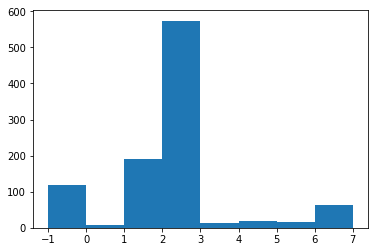

In [65]:
import matplotlib.pyplot as plt

plt.hist(labels,bins=8,)

plt.show()

In [ ]:
abs_sasa = []
for si in u.snapshots_indices:
    beta_coords = []
    for pocket in u.pockets(si):
        for beta in pocket.betas:
            beta_coords.append(beta.centroid)

    covered_sasa = alphaspace.getSASA(u.receptor.traj[si],np.array(beta_coords))
    sasa = alphaspace.getSASA(u.receptor.traj[si])
    abs_sasa.append(sasa - covered_sasa)

    print(np.count_nonzero(np.any((sasa - covered_sasa) > 0)),flush=True)